In [31]:
import asyncio
import random
from pathlib import Path
from typing import List
from datasets import Dataset
import nest_asyncio
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_openai import AzureChatOpenAI
from llama_index.readers.json import JSONReader


In [ ]:
from src.settings import settings

In [9]:
# Enable async
nest_asyncio.apply()

In [10]:
# Helper function
def gen_batches(iterable, n=50):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

# **Parsing and splitting the data**

In [11]:
DATA = Path("data")

In [13]:
reader = JSONReader()

In [28]:
documents = []
for name in ["bacteria", "fungi", "virus"]:
  documents.extend(reader.load_data(input_file = "/content/data" + "/" + "articles_data_" + name + ".json"))

In [30]:
print(len(documents))

3


In [ ]:
# Split text into semantic chunks using OpenAI embeddings
text_splitter = SemanticChunker(embeddings=OpenAIEmbeddings(model="text-embedding-3-large", api_key=settings.OPENAI_API_KEY))
splitted_documents = await text_splitter.atransform_documents(documents=[Document(page_content=doc.text) for doc in documents])

# **Generating Questions**

In [ ]:
llm = AzureChatOpenAI(
    azure_deployment="gpt-4o",  # or your deployment
    api_version=settings.AZURE_API_VERSION,  # or your api version
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [ ]:
# Output pydantic parser
class Questions(BaseModel):
    """Generated Synthetic Questions"""
    questions: List[str] = Field(..., description="List of generated questions")
question_output_parser = PydanticOutputParser(pydantic_object=Questions)

In [ ]:
system = "You are a synthetic question-answer pair generator. Given a chunk of context " \
    "about some topic(s), generate 3 example questions a user could ask and would" \
    " be answered using information from the chunk. For example, if the given con" \
    "text was a Wikipedia paragraph about the United States, an example question " \
    "could be 'How many states are in the United States?'. The questions should b" \
    "e able to be answered in a few words or less. Include only the questions in " \
    "your response.\n{format_instructions}"

In [ ]:
generate_instructions_prompt = ChatPromptTemplate.from_messages(
    messages=[
        ("system", system),
        ("human", "{chunk}")
    ]
)
generate_instructions_chain = generate_instructions_prompt | llm | question_output_parser

In [ ]:
# Format prompts for each chunk
prompts = [
    {"chunk": doc.page_content, "format_instructions": question_output_parser.get_format_instructions()}
    for doc in splitted_documents
]

In [ ]:
# Generate all the questions
all_questions = []
batch_size = 50
total = len(prompts) // batch_size + 1

for idx, batch in enumerate(gen_batches(prompts, batch_size)):
        print(f"Batch {idx}/{total} processing...")
        all_questions.extend(await generate_instructions_chain.abatch(batch, return_exceptions=False))
        print(f"Batch {idx}/{total} processed! sleeping not to exceed rpm...")
        await asyncio.sleep(60)
        print(f"Batch {idx}/{total} done!")

In [ ]:
print(all_questions[0].json(indent=4))

In [ ]:
print(f"Number of expected questions: {len(all_questions) * 3}")
print(f"Number of actual questions: {sum((len(q.questions) for q in all_questions))}")

In [ ]:
good_cases = [
    {"questions": q.questions, "context": context}
    for q, context in zip(all_questions, splitted_documents)
    if len(q.questions) == 3
]

# **Generating Answers based on question and context**

In [ ]:
# Output pydantic parser
class Answer(BaseModel):
    """Generated Chain-of-though Style Answer"""
    answer: str = Field(..., description="Generated Chain-of-though answer")
parser = PydanticOutputParser(pydantic_object=Answer)

In [ ]:
system = "You are a helpful question answerer who can provide an answer given a question and relevant context." \
"Answer the question using the information given in the context. " \
"Here is things to pay attention to: \n- First provide ste" \
"p-by-step reasoning on how to answer the question. \n- In the re" \
"asoning, if you need to copy paste some sentences from the context, include " \
"them in ##begin_quote## and ##end_quote##. This would mean that things outsi" \
"de of ##begin_quote## and ##end_quote## are not directly copy paste from the" \
" context. \n- End your response with final answer in the form <A" \
"NSWER>: $answer, the answer should be succint."
user = "#### Question: {question} \n\n#### Context: {context}\n\n{format_instructions}"

In [ ]:
# Define one shot. Based on the example in paper
os_question = "The Oberoi family is part of a hotel company that has a head office in what city?"
os_context = "[The Oberoi family is an Indian family that is famous for its involvement in hotels, namely through The Oberoi Group]...[It is located in city center of Jakarta, near Mega Kuningan, adjacent to the sister JW Marriott Hotel. It is operated by The Ritz-Carlton Hotel Company. The complex has two towers that comprises a hotel and the Airlangga Apartment respectively]...[The Oberoi Group is a hotel company with its head office in Delhi.]"
os_user = f"#### Question: {os_question} \n\n#### Context: {os_context}" + "\n\n{format_instructions}"
os_json_answer = """```json
{{
    "answer": "##Reason: The document ##begin_quote## The Oberoi family is an Indian family that is famous for its involvement in hotels, namely through The Oberoi Group. ##end_quote## establishes that the Oberoi family is involved in the Oberoi group, and the document ##begin_quote## The Oberoi Group is a hotel company with its head office in Delhi. ##end_quote## establishes the head office of The Oberoi Group. Therefore, the Oberoi family is part of a hotel company whose head office is in Delhi. ##Answer: Delhi"
}}
```"""

In [ ]:
generate_answer_prompt = ChatPromptTemplate.from_messages(
    messages=[
        ("system", system),
        ("human", os_user),
        ("ai", os_json_answer),
        ("human", user)
    ]
)
generate_answer_chain = generate_answer_prompt | llm | parser

In [ ]:
# Format prompts for each chunk
prompts = []
prompts = [
    {
        "question": question,
        "context": casee["context"].page_content,
        "format_instructions": parser.get_format_instructions()
    }
    for casee in good_cases
    for question in casee["questions"]
]

In [ ]:
# Generate all the answers
_answers = []
batch_size = 100
total = len(prompts) // batch_size + 1

for idx, batch in enumerate(gen_batches(prompts, batch_size), start=1):
        print(f"Batch {idx}/{total} processing...")
        _answers.extend(await generate_answer_chain.abatch(batch, return_exceptions=False))
        print(f"Batch {idx}/{total} processed! sleeping...")
        await asyncio.sleep(60)
        print(f"Batch {idx}/{total} done!")

In [ ]:
print(_answers[0].json(indent=4))

In [ ]:
final_data = [
    {
        "question": question,
        "answer": answer,
        "context": casee["context"].page_content
    }
    for casee in good_cases
    for question, answer in zip(casee["questions"], _answers[:len(casee["questions"])])
]

In [ ]:
from IPython.display import display, Markdown

index = 30

display(Markdown("#### Context"))
display(Markdown(final_data[index]["context"]))

display(Markdown("#### Question"))
display(Markdown(final_data[index]["question"]))

display(Markdown("#### Answer"))
display(Markdown(final_data[index]["answer"]))

# **Populate the dataset**

In [ ]:
# Create empty dataset
dataset = Dataset.from_dict({})

In [ ]:
num_distract = 3  # Number of distractor documents
p = 0.9  # Probability of including the oracle document

# Group entries by unique contexts to avoid selecting the same context
context_to_entries = {}
for entry in final_data:
    context_to_entries.setdefault(entry["context"], []).append(entry)

# Flatten all unique contexts
unique_contexts = list(context_to_entries.keys())

for i, entry in enumerate(final_data):
    datapt = {
        "id": f"seed_task_{dataset.num_rows}",
        "type": "general",
        "question": entry["question"],
        "context": None,
        "oracle_context": entry["context"],
        "cot_answer": entry["answer"],
        "instruction": None
    }

    # Get distractor documents by selecting among different contexts
    available_contexts = [ctx for ctx in unique_contexts if ctx != entry["context"]]
    distractor_docs = random.sample(available_contexts, k=num_distract)

    # Create the docs list with the chunk (oracle document) at the beginning
    docs = [entry["context"]] + distractor_docs

    # Decide whether to replace the oracle document with a random distractor document
    # With a probability of 1 - p, the oracle document is replaced by a randomly selected distractor document.
    if random.uniform(0, 1) >= p:
        docs[0] = random.choice(distractor_docs)

    random.shuffle(docs)

    datapt["context"] = {
        "title": [["placeholder_title"] * (num_distract + 1)],
        "sentences": [docs]
    }

    # Construct model instruction
    datapt["instruction"] = "\n".join([f"<DOCUMENT>{str(doc)}</DOCUMENT>" for doc in docs]) + "\n" + entry["question"]

    # Add the datapoint to the dataset
    dataset = dataset.add_item(datapt)

In [ ]:
# Example
dataset[0]

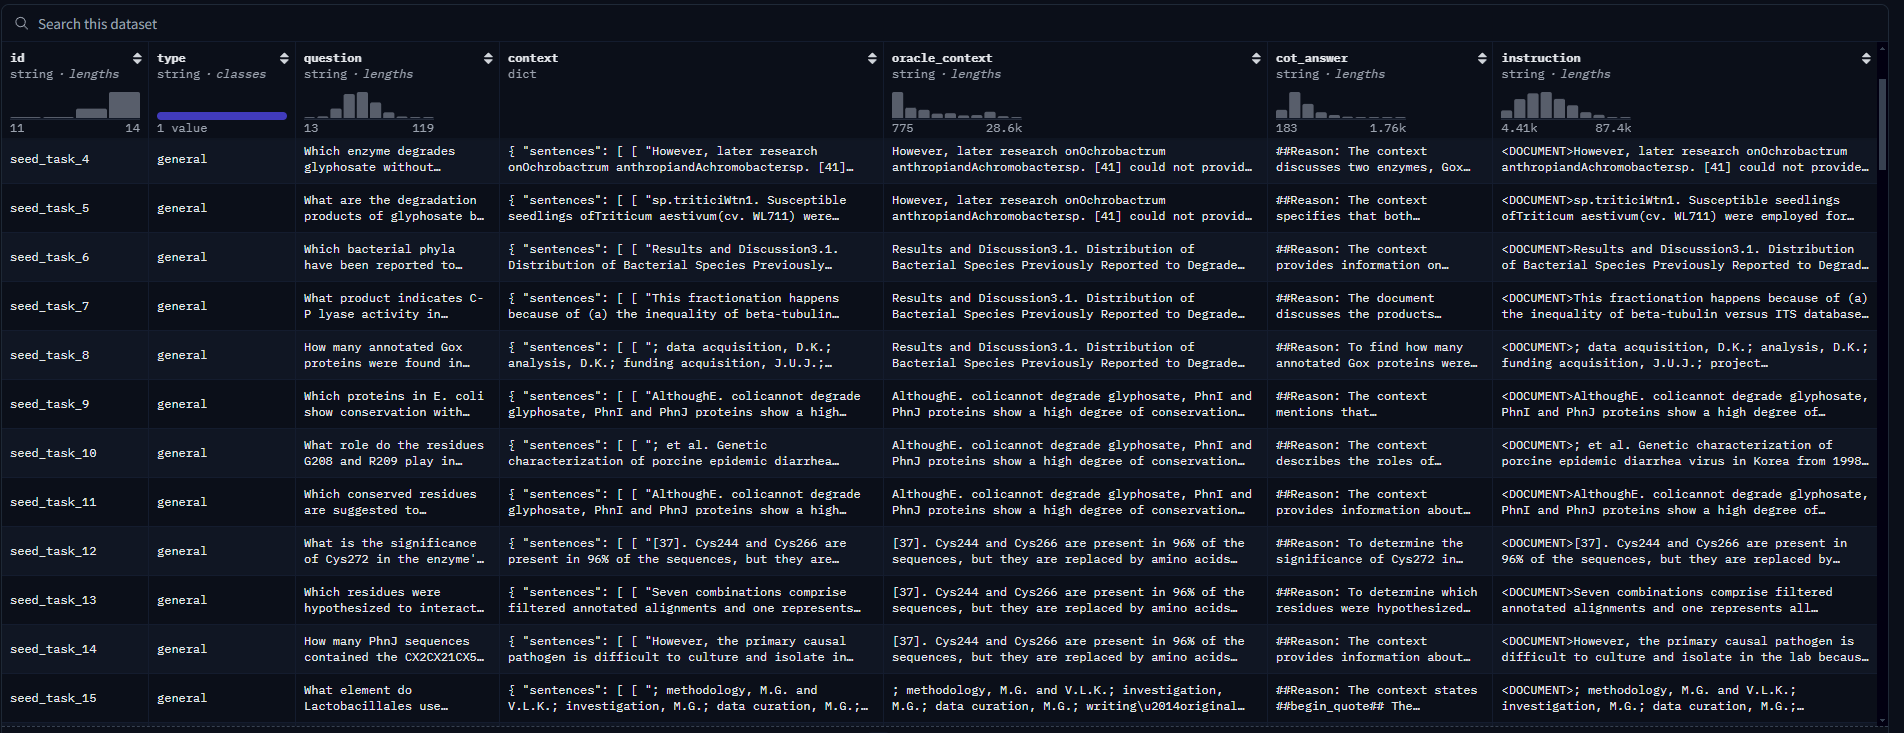